# Patch-Level Similarity Matching with DINOv3


### Setup

In [11]:
pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.3.0
    Uninstalling gradio_client-1.3.0:
      Successfully uninstalled gradio_client-1.3.0
  Attempting uninstall: gradio
    Found existing installation: gradio 4.44.1
    Uninstalling gradio-4.44.1:
      Successfully uninstalled gradio-4.44.1


In [3]:
# import huggingface_hub as hf
# hf.login()

In [1]:
import torch
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import gradio as gr
import io

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load Model

In [3]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vits16-pretrain-lvd1689m")
model = AutoModel.from_pretrained(
    "facebook/dinov3-vits16-pretrain-lvd1689m",
    dtype=torch.float16,
    device_map="auto",
    attn_implementation="sdpa"
)
model.eval()

preprocessor_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/86.4M [00:00<?, ?B/s]

DINOv3ViTModel(
  (embeddings): DINOv3ViTEmbeddings(
    (patch_embeddings): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (rope_embeddings): DINOv3ViTRopePositionEmbedding()
  (layer): ModuleList(
    (0-11): 12 x DINOv3ViTLayer(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attention): DINOv3ViTAttention(
        (k_proj): Linear(in_features=384, out_features=384, bias=False)
        (v_proj): Linear(in_features=384, out_features=384, bias=True)
        (q_proj): Linear(in_features=384, out_features=384, bias=True)
        (o_proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (layer_scale1): DINOv3ViTLayerScale()
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): DINOv3ViTMLP(
        (up_proj): Linear(in_features=384, out_features=1536, bias=True)
        (down_proj): Linear(in_features=1536, out_features=384, bias=True)
        (act_fn): GELUActivation()
 

### Helper functions

In [4]:
def display_image(img, rows,cols):
    W, H = img.size
    patch_w = W / rows
    patch_h = H / cols

    plt.figure(figsize=(8,8))
    plt.imshow(img)

    # Draw vertical lines
    for i in range(1, rows):
        plt.axvline(i * patch_w, color='white', linestyle='--', linewidth=0.8)

    # Draw horizontal lines
    for i in range(1, cols):
        plt.axhline(i * patch_h, color='white', linestyle='--', linewidth=0.8)

    plt.axis('off')
    plt.show()


def get_patch_embeddings(img, ps=16, device="cuda"):
    inputs = processor(images=img, return_tensors="pt").to(device, torch.float16)
    B, C, H, W = inputs["pixel_values"].shape
    rows, cols = H // ps, W // ps

    with torch.no_grad():
        out = model(**inputs)

    hs = out.last_hidden_state.squeeze(0).detach().cpu().numpy()

    # remove CLS + register tokens
    n_patches = rows * cols
    patch_embs = hs[-n_patches:, :].reshape(rows, cols, -1)

    # flatten and normalize
    X = patch_embs.reshape(-1, patch_embs.shape[-1])
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)

    return patch_embs, Xn, rows, cols

def compute_patch_similarity(patch_embs, patch_embs_norm, row, col):
    rows, cols, dim = patch_embs.shape
    patch_idx = row * cols + col  # flatten index

    # cosine similarity via dot product
    sim = patch_embs_norm @ patch_embs_norm[patch_idx]
    sim_map = sim.reshape(rows, cols)
    sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min() + 1e-8)


    return sim_map

def overlay_similarity(img, sim_map, alpha=0.5, cmap="hot"):
    W, H = img.size

    # Expand sim_map (14x14) to full resolution via Kronecker upsampling
    sim_map_resized = np.kron(sim_map, np.ones((H // sim_map.shape[0], W // sim_map.shape[1])))

    # Plot to figure (no plt.show())
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)
    ax.imshow(sim_map_resized, cmap=cmap, alpha=alpha)

    # Draw patch grid
    patch_w = W / sim_map.shape[1]
    patch_h = H / sim_map.shape[0]
    for i in range(1, sim_map.shape[1]):
        ax.axvline(i * patch_w, color='white', linestyle='--', linewidth=0.8)
    for i in range(1, sim_map.shape[0]):
        ax.axhline(i * patch_h, color='white', linestyle='--', linewidth=0.8)

    ax.axis('off')

    # Convert figure to PIL image (so Gradio can show it)
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    overlay_img = Image.open(buf)

    return overlay_img

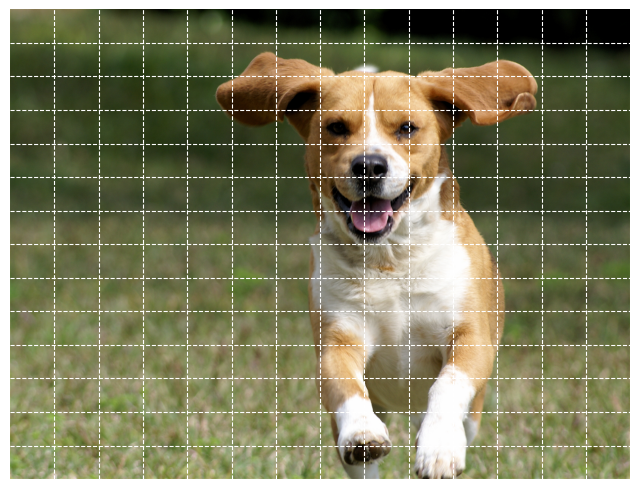

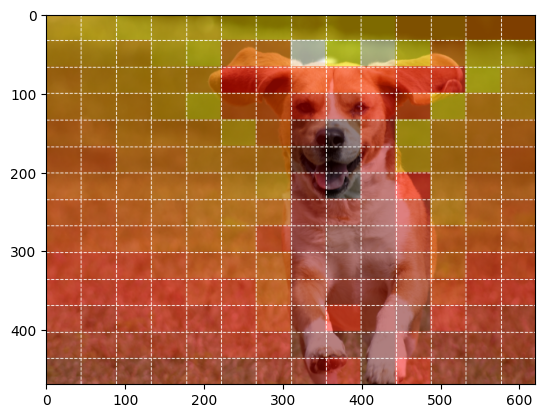

In [6]:
img = Image.open("dog.jpg")
patch_embs,patch_embs_norm,rows,cols= get_patch_embeddings(img,ps=16, device=device)
display_image(img,rows,cols)
sim_map = compute_patch_similarity(patch_embs, patch_embs_norm, 1, 7)
result_img = overlay_similarity(img,sim_map)
plt.imshow(result_img)

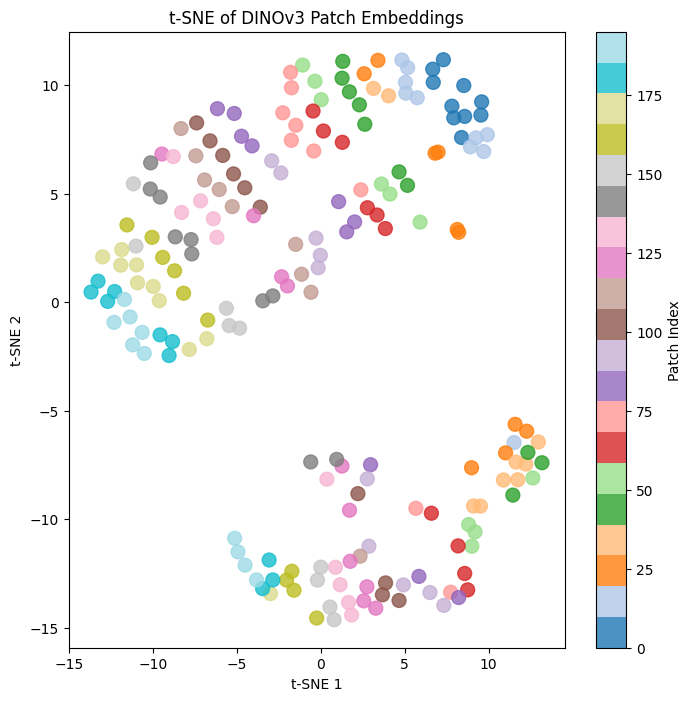

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X = patch_embs_norm  # shape: [num_patches, dim]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)  # shape: [num_patches, 2]

# Plotting
rows, cols = int(np.sqrt(X.shape[0])), int(np.sqrt(X.shape[0]))  # assuming square grid
plt.figure(figsize=(8,8))
scatter = plt.scatter(
    X_tsne[:,0], X_tsne[:,1],
    c=np.arange(X.shape[0]),  # color by patch index or position
    cmap='tab20',
    s=100,
    alpha=0.8
)
plt.colorbar(scatter, label="Patch Index")
plt.title("t-SNE of DINOv3 Patch Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


### Interactive visualization

In [36]:
selected_patch = {"row": 0, "col": 0}

def init_states(img):
    if img is None:
        return gr.update(value=None), None
    patch_embs, patch_embs_norm, rows, cols = get_patch_embeddings(img, ps=16, device=device)

    sim_map = compute_patch_similarity(patch_embs, patch_embs_norm, 0, 0)
    result_img = overlay_similarity(img, sim_map, alpha=0.6, cmap="hot")

    state = {
        "img": img,
        "patch_embs": patch_embs,
        "patch_embs_norm": patch_embs_norm,
        "grid_size": rows,
        "alpha": 0.6,
        "overlay_img":result_img,
    }

    return state, result_img

def store_patch(evt, state):
    if state is None or evt is None:
        return state

    rows = state["grid_size"]
    cols = rows
    overlay_img = state["overlay_img"]
    overlay_W, overlay_H = overlay_img.size
    x_click, y_click = evt.index     # coordinates from click event

    # Map click coordinates to original patch grid
    col = int(x_click / overlay_W * cols)
    row = int(y_click / overlay_H * rows)

    # Clamp to valid range
    col = min(max(col, 0), cols - 1)
    row = min(max(row, 0), rows - 1)

    # Store in global or state dictionary
    selected_patch["row"] = row
    selected_patch["col"] = col


    return state

def reload_overlay(evt: gr.SelectData,state):
    if state is None:
        return None
    store_patch(evt, state)
    row, col = selected_patch["row"], selected_patch["col"]
    img = state["img"]
    patch_embs = state["patch_embs"]
    patch_embs_norm = state["patch_embs_norm"]
    alpha = state["alpha"]
    sim_map = compute_patch_similarity(patch_embs, patch_embs_norm, row, col)
    result_img = overlay_similarity(img, sim_map, alpha=alpha, cmap="hot")
    return result_img

with gr.Blocks() as demo:
    state_store = gr.State()
    gr.Markdown("Patch Similarity Visualizer")

    with gr.Row():
        img_input = gr.Image(type="pil", label="Upload image")
        output_img = gr.Image(type="pil", label="Similarity overlay",interactive=True)

    img_input.change(fn=init_states, inputs=[img_input], outputs=[state_store, output_img])

    output_img.select(fn=reload_overlay, inputs=[state_store], outputs=[output_img])



In [37]:
demo.launch(share=True, debug=True, prevent_thread_lock=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d06735fd43285c16c8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://d06735fd43285c16c8.gradio.live
